63f78014766fd30436c18a79_Hyperspace - navbar logo.png

# Classic Search With Hyperspace
This notebook demonstrates the use of Hyperspace engine for classic search, combining keyword and value matching.
For more info, see the [Hyperspace documentation](https://docs.hyper-space.io/hyperspace-docs/getting-started/overview).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hyper-space-io/QuickStart/blob/master/DataSets/CrimesInChicago/CrimesInChicago_ClassicSearch.ipynb)
## The Dataset - Crimes In Chicago Dataset
From Kaggle:
"This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified. This data includes unverified reports supplied to the Police Department. The preliminary crime classifications may be changed at a later date based upon additional investigation and there is always the possibility of mechanical or human error. Therefore, the Chicago Police Department does not guarantee (either expressed or implied) the accuracy, completeness, timeliness, or correct sequencing of the information and the information should not be used for comparison purposes over time."

The [dataset](https://www.kaggle.com/datasets/chicago/chicago-crime) can be downloaded from [Hyperspace git](https://github.com/hyper-space-io/QuickStart/blob/main/DataSets/CrimesInChicago/100k-crimes-dataset-processed_data.zip).

## The Dataset Fields
1. **Case Number {'type': 'keyword'}** - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
2. **Date {'type': 'date', 'format': 'MM/dd/yyyy hh:mm:ss a'}** - Date when the incident occurred. this is sometimes a best estimate.
3. **Block {'type 'keyword'}** -The partially redacted address where the incident occurred, placing it on the same block as the actual address.
4. **IUCR {'type 'keyword'}** - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
5. **Primary Type {'type 'keyword'}** - The primary description of the IUCR code.
6. **Description {'type 'keyword'}** - The secondary description of the IUCR code, a subcategory of the primary description.
7. **Location Description {'type 'keyword'}** - Description of the location where the incident occurred.
8. **Arrest {'type 'boolean'}** - Indicates whether an arrest was made.
9. **Domestic {'type 'boolean'}** - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
10. **Beat {'type 'integer'}** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
11. **District {'type 'integer'}** - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
12. **Ward {'type 'integer'}** - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
13. **Community Area {'type 'integer'}** - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
14. **FBI Code {'type 'keyword'}** - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
15. **X Coordinate {'type 'integer'}** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
16. **Y Coordinate {'type 'integer'}** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
17. **Year {'type 'integer'}** - Year the incident occurred.
18. **Updated On {'type 'date', 'format 'MM/dd/yyyy hh:mm:ss a'}** - Date and time the record was last updated.
19. **Latitude {'type 'float'}** - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
20. **Longitude {'type 'float'}** - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
21. **Location {'type 'geo_point', 'struct_type 'list'}** - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.


# Setting up the Hyperspace Environment
Setting up the environment and running the query includes the following steps
1. Download and install the client API
2. Connect to a server
3. Create data schema file
4. Create collection
5. Ingest data
6. Run query

## 1. Install the Hyperspace client API
Hyperspace API can be installed directly from git, using the following command:

In [1]:
#!pip uninstall hyperspace
#!pip install git+https://github.com/hyper-space-io/hyperspace-py

### Supporting functions

In [2]:

import support_functions as sfunc
import support_percentile as sperc
import support_query_doc as squery


### Download dataset

In [3]:

data_url = "https://hyperspace-datasets.s3.eu-central-1.amazonaws.com/100k-crimes-dataset-processed_data.zip"
sfunc.download_data(data_url, "./100k-crimes-dataset-processed_data.zip")
sfunc.unzip_file("./100k-crimes-dataset-processed_data.zip")


The file ./100k-crimes-dataset-processed_data.zip already exists and is not empty.
Success! Files have been extracted to ./


## 2. Connect to the server

Once the Hyperspace API is installed, the database can be accessed by creating a local instance of the Hyperspace client. This step requires host address, username and password.

In [4]:

import hyperspace
from getpass import getpass

username    = "maxn@hyper-space.io"
host        = "https://trial.prod.hyper-space.xyz/"
my_password = "Mn123456#"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=my_password)
# hyperspace_client = hyperspace.HyperspaceClientApi(host=host, username=username, password=getpass())
print(hyperspace_client)


We check the status before proceeding, also delete collection if exist ... 

In [5]:
collections_info = hyperspace_client.collections_info()
sfunc.pprint(collections_info)
if 'CrimesInChicago' in collections_info['collections'] :
    collections_info = hyperspace_client.delete_collection('CrimesInChicago')
    collections_info = hyperspace_client.collections_info()
    sfunc.pprint(collections_info)



{'collections': {'CrimesInChicago': {'creation_time': '2024-01-18T08:02:45Z',
                                     'last_query_time': '2024-01-18T08:03:41Z',
                                     'size': 100000}}}
{'collections': {}}


## 3. Create a Data Schema File

Similarly to other search databases, Hyper-Space database requires a configuration file that outlines the data schema. Here, we create a config file that corresponds to the fields of the given dataset.

For vector fields, we also provide the index type to be used, and the metric. . Current options for index include "**brute_force**", "**hnsw**", "**ivf**", and "**bin_ivf**" for binary vectors, and "**IP**" (inner product) as a metric for floating point vectors and "**Hamming**" ([hamming distance](https://en.wikipedia.org/wiki/Hamming_distance)) for binary vectors.
Note that the key 'low_cardinality' enables faster search for low cardinality fields.

In [6]:


config = {
  "configuration": {
    "ID": {
      "type": "keyword",
      "id": True
    },
    "Case Number": {
      "type": "keyword"
    },
    "Date": {
      "type": "date",
      "format": "MM/dd/yyyy hh:mm:ss a"
    },
    "Block": {
      "type": "keyword"
    },
    "IUCR": {
      "type": "keyword"
    },
    "Primary Type": {
      "type": "keyword"
    },
    "Description": {
      "type": "keyword"
    },
    "Location Description": {
      "type": "keyword"
    },
    "Arrest": {
      "type": "boolean"
    },
    "Domestic": {
      "type": "boolean"
    },
    "Beat": {
      "type": "integer"
    },
    "District": {
      "type": "integer"
    },
    "Ward": {
      "type": "integer"
    },
    "Community Area": {
      "type": "integer"
    },
    "FBI Code": {
      "type": "keyword"
    },
    "X Coordinate": {
      "type": "integer"
    },
    "Y Coordinate": {
      "type": "integer"
    },
    "Year": {
      "type": "integer"
    },
    "Updated On": {
      "type": "date",
      "format": "MM/dd/yyyy hh:mm:ss a"
    },
    "Latitude": {
      "type": "float"
    },
    "Longitude": {
      "type": "float"
    },
    "Location": {
      "type": "geo_point",
      "struct_type": "list"
    }
  }
}

with open('crime-config.json', 'w') as f:
    f.write(sfunc.json.dumps(config, indent=2))



## 4. Create Collection
The Hyerspace engine stores data in Collections, where each collection commonly hosts data of similar context, etc. Each search is then performed within a collection. We create a collection using the command "**create_collection**(schema_filename, collection_name)".

In [7]:
collection_name = 'CrimesInChicago'

if collection_name not in hyperspace_client.collections_info()["collections"]:
  hyperspace_client.create_collection('crime-config.json', collection_name)

hyperspace_client.collections_info()


{'collections': {'CrimesInChicago': {'creation_time': '2024-01-18T08:53:36Z',
   'size': 0}}}

# 5. Ingest data

In the next step we ingest the dataset in batches of 500 documents. This number can be controlled by the user, and in particular, can be increased in order improve ingestion time. We add batches of data using the command **add_batch**(batch, collection_name).

In [8]:
dataset_path = '100k-crimes-dataset-processed_data.json'


hyperspace_client.clear_collection(collection_name)

sfunc.batch_ingest_data(hyperspace_client, dataset_path, 0 , config, collection_name) 

hyperspace_client.commit(collection_name)


0 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
1000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
1500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
2000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
2500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
3000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
3500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
4000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
4500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
5000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
5500 {'code': 200,
 'mess

46000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
46500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
47000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
47500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
48000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
48500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
49000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
49500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
50000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
50500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
51000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
51500 {'co

92000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
92500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
93000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
93500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
94000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
94500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
95000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
95500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
96000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
96500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
97000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
97500 {'co

{'code': 200, 'message': 'Dataset committed successfully', 'status': 'OK'}

### Check collection size after ingestion

In [9]:
print(hyperspace_client.collections_info())

{'collections': {'CrimesInChicago': {'creation_time': '2024-01-18T08:53:36Z', 'size': 100000}}}


## 6. Define Logic and Run a Query
We build a search query using Hyper-space. we first select one document from the datset, document "1022", lets take a look in this document 


In [10]:

query_doc = hyperspace_client.get_document(collection_name, "1022")
sfunc.pprint(query_doc)

{'Arrest': True,
 'Beat': 531,
 'Block': '114XX S PRAIRIE AVE',
 'Case Number': 'HY413236',
 'Community Area': 49,
 'Date': 1441561500,
 'Description': 'AGGRAVATED:KNIFE/CUTTING INSTR',
 'District': 5,
 'Domestic': False,
 'FBI Code': '04B',
 'ID': '1022',
 'IUCR': '0420',
 'Latitude': 41.686521024,
 'Location': [41.686521024, -87.61683831],
 'Location Description': 'RESIDENCE',
 'Longitude': -87.61683831,
 'Primary Type': 'BATTERY',
 'Updated On': 1518270601,
 'Ward': 9,
 'X Coordinate': 1179956,
 'Y Coordinate': 1829174,
 'Year': 2015}


We will use a very simple logic, which matchs the description and location, and make sure case number doesn't match so we won't get back the same result.

We use the following logic:


*   document/case will match if it has the same "Description" and not the same "Case Number"
*   document/case will also match if it happended in the same "Block"
*   we boost the score by 5 points if geo "Location" is close (40 something)
*   we reduce the score by 5 points if the "District" is the same and case date if 40 to 100 days before the query case date

Score function is listed next :



In [11]:

def similarity_score(Q, V):
    score = 0.0

    if match('Description') and not match('Case Number'):
        score = rarity_max('Description')
        if geo_dist_match('Location',40):
            score += 5
        if match('District') and window_match('Date', 100, 40):
            score -= 5
    if match('Block'):
        score += rarity_max('Block')
    return score

# this is still not working
# hyperspace_client.set_function(similarity_score, collection_name)

sfunc.set_score_function(hyperspace_client, similarity_score, collection_name, score_function_name='similarity_score')

set_score_function : OK


### Next, we fire the query 

In [12]:
results = hyperspace_client.search({'params': query_doc},
                                        size=30,
                                        function_name='similarity_score',
                                        collection_name=collection_name)

sfunc.print_results( results, collection_name )


query run time   : 2.76734  ms
hits (candidates): 784
 1 id 1022       score =   14.440
 2 id 39728      score =   14.440
 3 id 57687      score =   14.440
 4 id 88471      score =   14.440
 5 id 11465      score =   12.000
 6 id 20874      score =   12.000
 7 id 25043      score =   12.000
 8 id 27522      score =   12.000
 9 id 31303      score =   12.000
10 id 31970      score =   12.000
11 id 32239      score =   12.000
12 id 33011      score =   12.000
13 id 33352      score =   12.000
14 id 34017      score =   12.000
15 id 34388      score =   12.000
16 id 34460      score =   12.000
17 id 34878      score =   12.000
18 id 35288      score =   12.000
19 id 35592      score =   12.000
20 id 37572      score =   12.000
21 id 37723      score =   12.000
22 id 38114      score =   12.000
23 id 38391      score =   12.000
24 id 38613      score =   12.000
25 id 39742      score =   12.000
26 id 39842      score =   12.000
27 id 43739      score =   12.000
28 id 47441      score =   1

We display the top 30 results. Note that results with similar score are ordered arbitrarily, so more complex logic will likely result in better outcome. 
lets take a look in the content of top matching document, we can see the match in "Description", no match in "Block" and "District" and match in "Location"

In [13]:

query_doc = hyperspace_client.get_document(collection_name, "39728")
sfunc.pprint(query_doc)

{'Arrest': False,
 'Beat': 531,
 'Block': '114XX S PRAIRIE AVE',
 'Case Number': 'HY478157',
 'Community Area': 49,
 'Date': 1440396000,
 'Description': 'FINANCIAL IDENTITY THEFT OVER $ 300',
 'District': 5,
 'Domestic': False,
 'FBI Code': '11',
 'ID': '39728',
 'IUCR': '1153',
 'Latitude': 41.686317912,
 'Location': [41.686317912, -87.616833241],
 'Location Description': 'RESIDENCE',
 'Longitude': -87.616833241,
 'Primary Type': 'DECEPTIVE PRACTICE',
 'Updated On': 1518270601,
 'Ward': 9,
 'X Coordinate': 1179958,
 'Y Coordinate': 1829100,
 'Year': 2015}


### Score function with some aggregation

we add count aggregation to get the number of cases with "Description" match and separate count for the number of cases with additional geo match.

In [14]:
def similarity_score_aggregations(Q, V):
    score = 0.0

    if match('Description') and not match('Case Number'):
        aggregate_count("count of cases")

        score = rarity_max('Description')
        if geo_dist_match('Location',40):
            aggregate_count("count of cases in nearby districts")
            score += 5
        if match('District') and window_match('Date', 100, 40):
            score -= 5
    if match('Block'):
        score += rarity_max('Block')
    return score

sfunc.set_score_function(hyperspace_client, similarity_score_aggregations, collection_name, score_function_name='similarity_score_aggregations')


set_score_function : OK


### Next, we fire the query 

In [15]:
results = hyperspace_client.search({'params': query_doc},
                                        size=30,
                                        function_name='similarity_score_aggregations',
                                        collection_name=collection_name)

        
sfunc.print_results( results, collection_name )

sfunc.pprint(results)

query run time   : 2.89342  ms
hits (candidates): 2214
 1 id 1022       score =   14.440
 2 id 39728      score =   14.440
 3 id 57687      score =   14.440
 4 id 88471      score =   14.440
 5 id 28344      score =   10.499
 6 id 29851      score =   10.499
 7 id 30088      score =   10.499
 8 id 30593      score =   10.499
 9 id 31410      score =   10.499
10 id 31619      score =   10.499
11 id 33502      score =   10.499
12 id 33680      score =   10.499
13 id 34205      score =   10.499
14 id 34265      score =   10.499
15 id 34310      score =   10.499
16 id 34400      score =   10.499
17 id 34433      score =   10.499
18 id 34574      score =   10.499
19 id 36870      score =   10.499
20 id 39348      score =   10.499
21 id 39706      score =   10.499
22 id 39894      score =   10.499
23 id 39936      score =   10.499
24 id 39984      score =   10.499
25 id 47398      score =   10.499
26 id 48238      score =   10.499
27 id 49480      score =   10.499
28 id 49608      score =   

we can see the aggregation section in the results where the two counts are listed



For more information, visit us at [Hyperspace](https://www.hyper-space.io/)

In [16]:
sfunc.pprint(hyperspace_client.collections_info())

{'collections': {'CrimesInChicago': {'creation_time': '2024-01-18T08:53:36Z',
                                     'last_query_time': '2024-01-18T08:54:27Z',
                                     'size': 100000}}}


# Performance - stream query firing

This is a bonus section, here we experiment streaming queries back to back, we fire a total of 1000 queries by 50 threads, and we measure total qps (query per second), latency as seen by the server, latency as seen by the client (much higher), total fire time measured via query start time and query end time. Have a look, very interesting.... 

### Preparing query document set

In [19]:

max_doc_index = 99999
doc_subset = []
subset_doc_count = 100 

doc_subset = squery.gen_local_doc_subset(hyperspace_client, collection_name, doc_subset, max_doc_index, subset_doc_count) 

query_doc = squery.gen_query_doc(config, doc_subset, subset_doc_count ) 

results = hyperspace_client.search({'params': query_doc},
                                        size=30,
                                        function_name='similarity_score_aggregations',
                                        collection_name=collection_name)

        
sfunc.print_results( results, collection_name )

    
    

query run time   : 3.10499  ms
hits (candidates): 9385
 1 id 87442      score =   22.117
 2 id 29431      score =   13.703
 3 id 53282      score =   13.703
 4 id 55354      score =   13.703
 5 id 67203      score =   13.703
 6 id 87935      score =   13.703
 7 id 88408      score =   13.703
 8 id 27564      score =    8.414
 9 id 27582      score =    8.414
10 id 27600      score =    8.414
11 id 29940      score =    8.414
12 id 33039      score =    8.414
13 id 34974      score =    8.414
14 id 34982      score =    8.414
15 id 34990      score =    8.414
16 id 36859      score =    8.414
17 id 36925      score =    8.414
18 id 37371      score =    8.414
19 id 39230      score =    8.414
20 id 39676      score =    8.414
21 id 39686      score =    8.414
22 id 39716      score =    8.414
23 id 39818      score =    8.414
24 id 39860      score =    8.414
25 id 39900      score =    8.414
26 id 40014      score =    8.414
27 id 42418      score =    8.414
28 id 42885      score =   

### Setting the threading mechanics and running ...

2024-01-18 12:44:59,476 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,480 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,602 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,634 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,634 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,672 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,742 WARNING Connection pool is full, discarding connection: trial.prod.hyper-space.xyz. Connection pool size: 40
2024-01-18 12:44:59,797 WARNING Connection pool is full, discarding c


 
Fired     1000 queries in interval of :     3.666 seconds, qps =  272.814
Total server latency                  :     8.322 seconds
Total document visited                :   4668676 
Time per document                     :   785.126 nano seconds
 



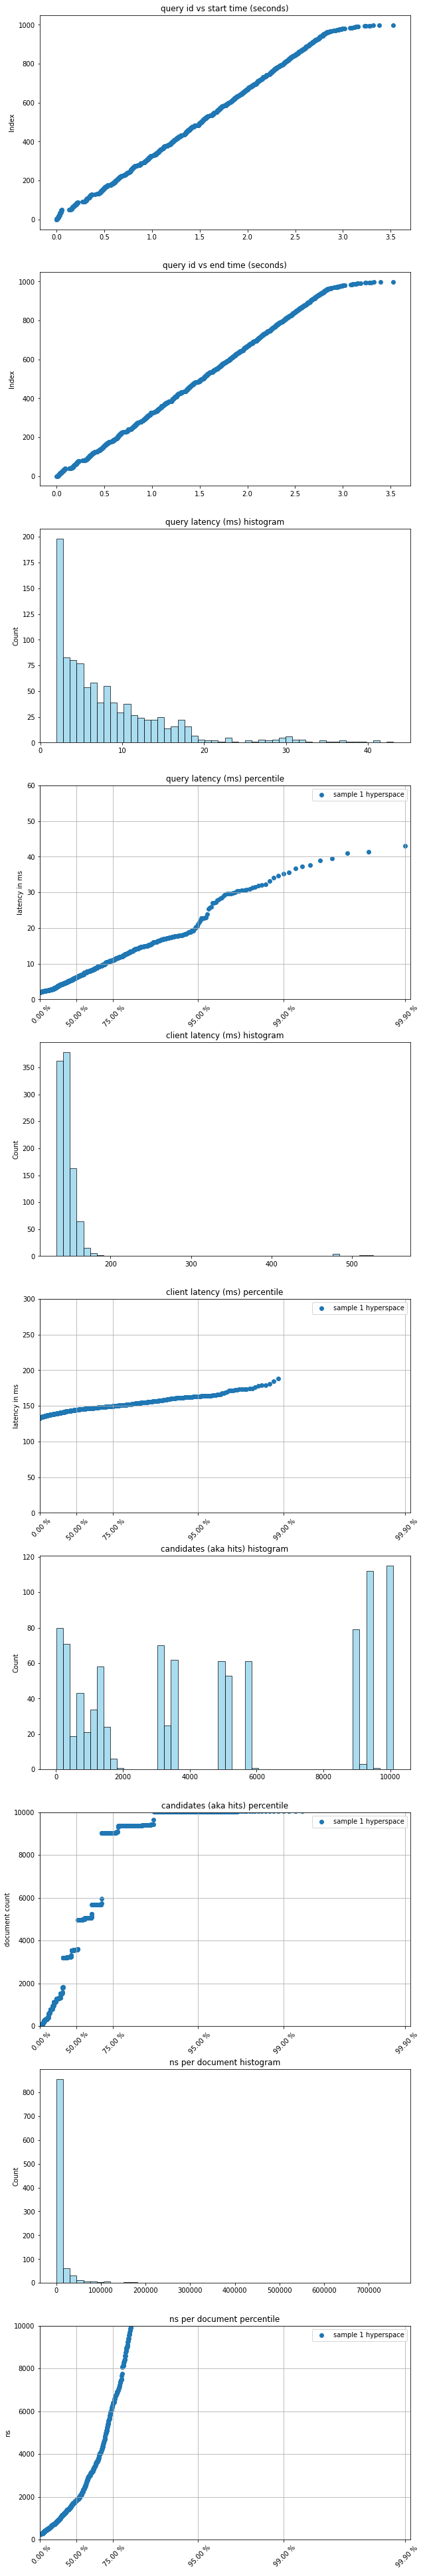

In [25]:
import threading
import time
import random
from queue import Queue
import matplotlib.pyplot as plt


# Number of times to call the search function per second
Total_Q   = 1000
N_threads = 50
T_latency = 0.02 # for dummie query

Q_per_thread = int(Total_Q / N_threads)


# Function that simulates the search operation (replace with your actual search function)
def dummie_search() :
    time.sleep(random.uniform(T_latency, 2*T_latency))  # Simulate the search taking between 1/N and 2/N seconds
    return "Search result"

# Function that simulates the search operation (replace with your actual search function)
def search():
    
    query_doc = squery.gen_query_doc(config, doc_subset, subset_doc_count )  # dynamic query document
    
    results = hyperspace_client.search({'params': query_doc},
                                        size=30,
                                        function_name='similarity_score',
                                        collection_name=collection_name)
    return results


# Function to execute the search function N times per second
def execute_search(results):
    # print("thread_id ", threading.get_ident())
    thread_id = threading.get_ident()
    stat = []
    for i in range(Q_per_thread):
        start_time = time.time_ns()  # Capture the start time in nanoseconds
        result = search()  # Call the search function
        end_time = time.time_ns()  # Capture the end time in nanoseconds
        completion_time = end_time - start_time
        if 0:
            print("thread_id %6d took_ms : %s start %.3f sec, end %.3f sec, latency %7.3f ms" % 
                  (thread_id,  result["took_ms"], start_time*1e-9, end_time*1e-9, completion_time*1e-6))
        stat.append([thread_id, start_time*1e-9, end_time*1e-9, completion_time*1e-6, result["took_ms"], result["candidates"]] )

    # print("stat ", stat)
    for tmp_stat in stat :
        results.put(tmp_stat)

    
# Create a queue to store the results and completion times
result_queue = Queue()

# Create a pool of threads
threads = []
for thread_id in range(N_threads):
    thread = threading.Thread(target=execute_search, args=[result_queue])
    # thread = threading.Thread(target=execute_search)
    threads.append(thread)

    
start = time.time_ns()

    
# Start the threads
for thread in threads:
    thread.start()

# Wait for all threads to finish
for thread in threads:
    thread.join()


stop = time.time_ns()

# Collect the results and completion times from the queues
all_results = []
while not result_queue.empty():
    all_results.append(result_queue.get())


# print("all_results ", all_results)

#    thread = threading.Thread(target=execute_search, args=(result_queue, completion_time_queue))

q_count = Total_Q
q_count = len(all_results)

delta = stop - start
print("\n \033[1m")
print("Fired %8d queries in interval of :  %8.3f seconds, qps = %8.3f" % ( q_count,  delta*1e-9, q_count/(delta*1e-9)) )

    

# Extract the kth element from each inner list
q_start_times = [inner_list[1] for inner_list in all_results]
q_end_times   = [inner_list[2] for inner_list in all_results]
q_client_seen_latency   = [inner_list[3] for inner_list in all_results]
q_took_ms     = [inner_list[4] for inner_list in all_results]
total_took_ms = sum(q_took_ms)
q_candidates  = [inner_list[5] for inner_list in all_results] # aka hits
q_took_ms_per_doc= [inner_list[4]/inner_list[5]*1e6 for inner_list in all_results] # aka hits

total_q_candidates = sum(q_candidates)

ns_per_doc = delta / total_q_candidates 
                                                                                                                

print("Total server latency                  :  %8.3f seconds"  % ( total_took_ms/1000))
print("Total document visited                :  %8d "           % ( total_q_candidates))
print("Time per document                     :  %8.3f nano seconds"  % ( ns_per_doc ))

print('\033[0m \n')

# Sort the kth_elements list
sorted_q_start_times = sorted(q_start_times)
sorted_q_end_times   = sorted(q_end_times)

sorted_q_start_times_zero = [tmp_seconds - sorted_q_start_times[0] for tmp_seconds in  sorted_q_start_times]
sorted_q_end_times_zero   = [tmp_seconds - sorted_q_end_times[0] for tmp_seconds in  sorted_q_end_times]

sorted_q_took_ms = sorted(q_took_ms)


# Create an x-axis for the scatter plot (optional)
x_values = list(range(len(sorted_q_start_times)))


# Create a new figure
plt.figure(figsize=(10, 70))
plt.subplot(10, 1, 1)  # 2 rows, 1 column, first subplot

# Plot the sorted elements as a scatter plot
plt.scatter( sorted_q_start_times_zero, x_values)

# Optionally, add labels and title to the plot
plt.ylabel("Index")
# plt.xlabel("query start time (sec)")
plt.title(f"query id vs start time (seconds)")

plt.subplot(10, 1, 2)  # 2 rows, 1 column, first subplot

# Plot the sorted elements as a scatter plot
plt.scatter( sorted_q_end_times_zero, x_values)

# Optionally, add labels and title to the plot
plt.ylabel("Index")
# plt.xlabel("query start time (sec)")
plt.title(f"query id vs end time (seconds)")


###########################################################
###########################################################
###########################################################
# 2 views of took_ms, latency seen by search master
###########################################################
###########################################################
###########################################################

plt.subplot(10, 1, 3)  # 2 rows, 1 column, first subplot


plt.hist(sorted_q_took_ms, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"query latency (ms) histogram")
plt.ylabel("Count")


plt.subplot(10, 1, 4)  # 2 rows, 1 column, first subplot


###########################################################
###########################################################
###########################################################

# should come from external json file
input_dict = {
    "fig_title"    : "query latency (ms) percentile",
    "x_axis_label" : "",
    "y_axis_label" : "latency in ms",
    "ylim"         : [0,60], 
    "x_ticks"      : [0.0, 0.5, 0.75, 0.95, 0.99, 0.999],

    "samples" : [
    {
    "legend" : "sample 1 hyperspace",
    "data"   : q_took_ms
    }
    ]
}

###########################################################
###########################################################
###########################################################


sperc.do_percentile(input_dict)

###########################################################
###########################################################
###########################################################
# 2 views of client_latency, latency seen by client
###########################################################
###########################################################
###########################################################

plt.subplot(10, 1, 5)  # 2 rows, 1 column, first subplot


plt.hist(q_client_seen_latency, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"client latency (ms) histogram")
plt.ylabel("Count")


plt.subplot(10, 1, 6)  # 2 rows, 1 column, first subplot


###########################################################
###########################################################
###########################################################

# should come from external json file
input_dict = {
    "fig_title"    : "client latency (ms) percentile",
    "x_axis_label" : "",
    "y_axis_label" : "latency in ms",
    "ylim"         : [0,300], 
    "x_ticks"      : [0.0, 0.5, 0.75, 0.95, 0.99, 0.999],

    "samples" : [
    {
    "legend" : "sample 1 hyperspace",
    "data"   : q_client_seen_latency
    }
    ]
}

###########################################################
###########################################################
###########################################################


sperc.do_percentile(input_dict)


###########################################################
###########################################################
###########################################################
# 2 views of candidates per query
###########################################################
###########################################################
###########################################################

plt.subplot(10, 1, 7)  # 2 rows, 1 column, first subplot


plt.hist(q_candidates, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"candidates (aka hits) histogram")
plt.ylabel("Count")


plt.subplot(10, 1, 8)  # 2 rows, 1 column, first subplot


###########################################################
###########################################################
###########################################################

# should come from external json file
input_dict = {
    "fig_title"    : "candidates (aka hits) percentile",
    "x_axis_label" : "",
    "y_axis_label" : "document count",
    "ylim"         : None, 
    "x_ticks"      : [0.0, 0.5, 0.75, 0.95, 0.99, 0.999],

    "samples" : [
    {
    "legend" : "sample 1 hyperspace",
    "data"   : q_candidates
    }
    ]
}

###########################################################
###########################################################
###########################################################


sperc.do_percentile(input_dict)

###########################################################
###########################################################
###########################################################
# 2 views of took_ms per document
###########################################################
###########################################################
###########################################################

plt.subplot(10, 1, 9)  # 2 rows, 1 column, first subplot


plt.hist(q_took_ms_per_doc, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"ns per document histogram")
plt.ylabel("Count")


plt.subplot(10, 1, 10)  # 2 rows, 1 column, first subplot


###########################################################
###########################################################
###########################################################

# should come from external json file
input_dict = {
    "fig_title"    : "ns per document percentile",
    "x_axis_label" : "",
    "y_axis_label" : "ns",
    "ylim"         : None, 
    "x_ticks"      : [0.0, 0.5, 0.75, 0.95, 0.99, 0.999],

    "samples" : [
    {
    "legend" : "sample 1 hyperspace",
    "data"   : q_took_ms_per_doc
    }
    ]
}

###########################################################
###########################################################
###########################################################


sperc.do_percentile(input_dict)

                                                                                                                

    
    
    
                                                                                                                
                                                                                                                
                                                                                                                
                                                                                                                

# Show the plot
plt.show()
    